# Exercício Adult data set

Este notebook se refere à modelagem feita para a máteria PCS5024 - Aprendizado estatístico e tinha como objetivo utilizar alguns modelos de aprendizado supervisionado para modelar o conjunto de dados AdultSet.

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import unicodedata

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import category_encoders as ce
from sklearn.preprocessing import LabelBinarizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.model_selection import learning_curve, validation_curve

import matplotlib.pyplot as plt
from matplotlib.ticker import *
import seaborn as sns

import os

#master_add="drive/My Drive/Edu/Mestrado/PCS5024 - Aprendizado estátistico/Predict_adult"
#if master_add not in os.getcwd():
#  os.chdir(master_add)

pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")


In [3]:
def plot_validation_curve(estimator,X,y,param_name,param_range,cv=3,scoring="neg_mean_squared_error"):
    train_scores, test_scores = validation_curve(estimator=estimator, X=X, y=y, 
                                                 param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    sns.set()
    fig,ax= plt.subplots(nrows=1, ncols=1, figsize=(20,5))
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    lw = 2
    sns.lineplot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="darkorange", lw=lw)
    sns.lineplot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [4]:
def norm_string(x):
    if x is None:
        return x
    try:
        tmp=unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII').encode('utf8', 'replace').decode()
    except:
        tmp=''
    item_norm=tmp.upper().strip()
    return item_norm


In [5]:
columns_name=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Target']

target="Target"
train=pd.read_csv("adult.data",sep=',',header=None,names=columns_name)
test=pd.read_csv("adult.test",sep=',',header=None,names=columns_name).drop(0)

def norm_cols(df,target):
  for col in df.columns:
    if df[col].dtype=="O":
      df[col]=df[col].apply(lambda x: norm_string(x))
    if col==target:
      df[col]=df[col].str.replace('.','')
  
  return df

train=norm_cols(train,target)
test=norm_cols(test,target)

<ipython-input-5-9dba2e55ec65>:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col]=df[col].str.replace('.','')


In [6]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target
0,39,STATE-GOV,77516,BACHELORS,13,NEVER-MARRIED,ADM-CLERICAL,NOT-IN-FAMILY,WHITE,MALE,2174,0,40,UNITED-STATES,<=50K
1,50,SELF-EMP-NOT-INC,83311,BACHELORS,13,MARRIED-CIV-SPOUSE,EXEC-MANAGERIAL,HUSBAND,WHITE,MALE,0,0,13,UNITED-STATES,<=50K
2,38,PRIVATE,215646,HS-GRAD,9,DIVORCED,HANDLERS-CLEANERS,NOT-IN-FAMILY,WHITE,MALE,0,0,40,UNITED-STATES,<=50K
3,53,PRIVATE,234721,11TH,7,MARRIED-CIV-SPOUSE,HANDLERS-CLEANERS,HUSBAND,BLACK,MALE,0,0,40,UNITED-STATES,<=50K
4,28,PRIVATE,338409,BACHELORS,13,MARRIED-CIV-SPOUSE,PROF-SPECIALTY,WIFE,BLACK,FEMALE,0,0,40,CUBA,<=50K


In [7]:
test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target
1,25,PRIVATE,"226,802.00",11TH,7.00,NEVER-MARRIED,MACHINE-OP-INSPCT,OWN-CHILD,BLACK,MALE,0.00,0.00,40.00,UNITED-STATES,<=50K
2,38,PRIVATE,"89,814.00",HS-GRAD,9.00,MARRIED-CIV-SPOUSE,FARMING-FISHING,HUSBAND,WHITE,MALE,0.00,0.00,50.00,UNITED-STATES,<=50K
3,28,LOCAL-GOV,"336,951.00",ASSOC-ACDM,12.00,MARRIED-CIV-SPOUSE,PROTECTIVE-SERV,HUSBAND,WHITE,MALE,0.00,0.00,40.00,UNITED-STATES,>50K
4,44,PRIVATE,"160,323.00",SOME-COLLEGE,10.00,MARRIED-CIV-SPOUSE,MACHINE-OP-INSPCT,HUSBAND,BLACK,MALE,"7,688.00",0.00,40.00,UNITED-STATES,>50K
5,18,?,"103,497.00",SOME-COLLEGE,10.00,NEVER-MARRIED,?,OWN-CHILD,WHITE,FEMALE,0.00,0.00,30.00,UNITED-STATES,<=50K


# EDA

In [8]:
def create_report(df):
  col=df.columns[0]
  temp=pd.DataFrame()
  temp.at["nulls",col]=df[df[col].isna()][col].count()
  temp=pd.concat([temp,df[[col]].describe()])
  return temp

def deep_describing(df):
  print("Entradas duplicadas neste conjunto são: {}".format(df[df.duplicated()]["age"].count()))
  report=pd.DataFrame()
  i=0
  for col in df.columns:
    if df[col].dtype in ["float64","int64"]:
      report=report.merge(create_report(df[[col]]),right_index=True,left_index=True,how='outer')
  print("\nEstatísticas básicas para as colunas númericas:")
  display(report)
  print("")
  report=pd.DataFrame()
  for col in df.columns:
    if df[col].dtype=="O":
      report=report.merge(create_report(df[[col]]),right_index=True,left_index=True,how='outer')
  print("\nEstatísticas básicas para as colunas categóricas:")
  display(report)

In [9]:
deep_describing(train)

Entradas duplicadas neste conjunto são: 24

Estatísticas básicas para as colunas númericas:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
nulls,0.00,0.00,0.00,0.00,0.00,0.00
count,"32,561.00","32,561.00","32,561.00","32,561.00","32,561.00","32,561.00"
mean,38.58,"189,778.37",10.08,"1,077.65",87.30,40.44
std,13.64,"105,549.98",2.57,"7,385.29",402.96,12.35
min,17.00,"12,285.00",1.00,0.00,0.00,1.00
25%,28.00,"117,827.00",9.00,0.00,0.00,40.00
50%,37.00,"178,356.00",10.00,0.00,0.00,40.00
75%,48.00,"237,051.00",12.00,0.00,0.00,45.00
max,90.00,"1,484,705.00",16.00,"99,999.00","4,356.00",99.00




Estatísticas básicas para as colunas categóricas:


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,Target
nulls,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,PRIVATE,HS-GRAD,MARRIED-CIV-SPOUSE,PROF-SPECIALTY,HUSBAND,WHITE,MALE,UNITED-STATES,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [10]:
deep_describing(test)

Entradas duplicadas neste conjunto são: 5

Estatísticas básicas para as colunas númericas:


,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
nulls,0.00,0.00,0.00,0.00,0.00
count,"16,281.00","16,281.00","16,281.00","16,281.00","16,281.00"
mean,"189,435.68",10.07,"1,081.91",87.90,40.39
std,"105,714.91",2.57,"7,583.94",403.11,12.48
min,"13,492.00",1.00,0.00,0.00,1.00
25%,"116,736.00",9.00,0.00,0.00,40.00
50%,"177,831.00",10.00,0.00,0.00,40.00
75%,"238,384.00",12.00,0.00,0.00,45.00
max,"1,490,400.00",16.00,"99,999.00","3,770.00",99.00




Estatísticas básicas para as colunas categóricas:


,age,workclass,education,marital-status,occupation,relationship,race,sex,native-country,Target
nulls,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
count,16281,16281,16281,16281,16281,16281,16281,16281,16281,16281
unique,73,9,16,7,15,6,5,2,41,2
top,35,PRIVATE,HS-GRAD,MARRIED-CIV-SPOUSE,PROF-SPECIALTY,HUSBAND,WHITE,MALE,UNITED-STATES,<=50K
freq,461,11210,5283,7403,2032,6523,13946,10860,14662,12435


In [11]:
TrainProfile = ProfileReport(train, title="Pandas Train Profiling Report", explorative=True)
TrainProfile.to_file("train.html")


In [12]:
TestProfile = ProfileReport(test, title="Pandas Test Profiling Report", explorative=True)
TestProfile.to_file("test.html")

In [13]:
lb=LabelBinarizer()
train[target]=lb.fit_transform(train[target])
test[target]=lb.transform(test[target])

print(lb.classes_)

['<=50K' '>50K']


In [14]:
for col in train.columns:
  print("{} = {}".format(col,train[(train[col]=="?")|(train[col].isna())][col].count()))

age = 0
workclass = 1836
fnlwgt = 0
education = 0
education-num = 0
marital-status = 0
occupation = 1843
relationship = 0
race = 0
sex = 0
capital-gain = 0
capital-loss = 0
hours-per-week = 0
native-country = 583
Target = 0


In [15]:
for col in test.columns:
  print("{} = {}".format(col,test[(test[col]=="?")|(test[col].isna())][col].count()))

age = 0
workclass = 963
fnlwgt = 0
education = 0
education-num = 0
marital-status = 0
occupation = 966
relationship = 0
race = 0
sex = 0
capital-gain = 0
capital-loss = 0
hours-per-week = 0
native-country = 274
Target = 0


## Model

Os conjuntos de treino e teste estão bem balanceados, sendo que as estatíticas dos dois conjuntos se assemelham muito, conforme tabelas acima.

Foi necessário um tratamento nos dados alvo para normalizar a o texto nos dois campos de forma a manter a mesma função de codificação de texto para campo númerico.

Há duplicatas no conjunto de treino (23 entradas) e no conjunto de teste (5 entradas), porém por se tratar de dados anonimizados obtidos pelo Censo Americano, faz sentido termos dados idênticos, apesar de baixa probabilidade. Dessa forma, iremos manter os dados duplicados e excluí-los posteriormente para vermos o impacto.

Em algumas coluna há dados nulos ou inválidos (valor "?") nas colunas:
- workclass (1836 entradas no conjunto de treino e 963 no conjunto de teste)
- occupation (1843 entradas no conjunto de treino e 966 no conjunto de teste)
- native-country (583 entradas no conjunto de treino e 274 no conjunto de teste)
Represetam aproximadamente 5% dos conjuntos de treino e teste, o que não impactaria muito no modelo se fossem excluídas. Porém com a finalidade de teste e imaginando um cenário de aplicação real do modelo, seria interessante aplicar um tratamento nestes casos para que a predição fosse gerada mesmo com nulos ou inválidos.
Este tratamento será testado, porém pode englobar:
1 - Usar dados inválidos como uma nova categoria;
2 - Aplicar a moda da coluna;
3 - Aplicar um modelo supervisionado nas demais variáveis independentes para prencher os faltantes;
4 - Aplicar um modelo supervisionado usando a variável Target para preencher os faltantes.  

A hipotese 3 pode incluir co-linearidade nas variáveis independentes, o que em modelos parâmetricos não é ideal. Como usaremos modelos não parâmetricos, essa co-linearidade pode não ser problema.

A Hipotese 4 deve ser feita considerando a possibilidade de "vazamento de dados" (*data likeage*) pois usando a variável alvo para preencher os valores dos campos faltantes irá acarretar no acréscimo de peso desta variável independente como preditor da variável alvo. Visto isso, é recomendado que ao fazermos isso, separamos um novo conjunto de dados a partir do conjunto de treino para treinar este modelo de preenchimento. Estes dados do conjunto de preenchimento devem ser excluídos da base de treino e teste para não gerar vazamento de dados.

A correlação phi indica uma boa associação da variável alvo com os campos:
- Relationship
- education
- marital status
- sex

estas correlações nos indicam algo, porém devem ser validadas no modelo.


A variável target possui 2 classes que estão desbalanceadas, aproximadamente 24% do conjunto de treino e do conjunto de teste são pertencentes à classe ">50K", os demais 76% representam a classe "<=50K". Como o desbalanceamento existe porém não é critico, méticas como área sobre a curva do operador receptor (ROC AUC) podem ser utilizadas já que é resistente ao desbalanceamento, entretanto ainda podemos utilizar métricas mais recomendadas e mais robustas a esse problema, como F1, MCC (*Mathew's Cohen Kappa*) e *Area under the Average Precision Curve*

Para pré-processamento, devemos olha para o encoding dos dados categóricos, partindo do uso de *One-Hot Encoding*, mais básico, até mesmo o uso de *Target encoding*.

A outra etapa de pré-processamento é a normalização dos dados númericos. Seguindo o mesmo princípio de teste, começamos usando *Min-Max Scaler* e normalização, entre outros.

Cabe salientar que algumas colunas como *capital-gain* e *capital-loss* estão com aproximadamente 90% e 95%, respectivamente, de entradas com valor 0, tanto no conjunto de treino quanto no conjunto de teste, o que pode gerar um impacto negativo. Portanto, provavelmente esta feature poderá ser excluída do modelo.

Aparentemente o país "HOLAND-NETHERLANDS" não existe no conjunto de teste.

In [74]:
Knn=KNeighborsClassifier()
rndmForest=RandomForestClassifier()

encoding=ce.OneHotEncoder()
cv=model_selection.KFold(n_splits=5,shuffle=True, random_state=0)
scaler=preprocessing.MinMaxScaler()
metrics_={"f1":metrics.f1_score,
         "Accuracy":metrics.accuracy_score,
         "Precision":metrics.precision_score,
         "Recall":metrics.recall_score}

In [66]:
from sklearn.compose import ColumnTransformer

In [67]:
cat_feat=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
numeric_feat=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

In [68]:
def fit_cv(model,df,target_var,encoding,cat_feat,scaler,numeric_feat,cv,metrics):
  X=encoding.fit_transform(df[cat_feat])
  X[numeric_feat]=scaler.fit_transform(df[numeric_feat])
  Y=df[target_var]
  performance_df=pd.DataFrame()
  print(X.shape)
  for i,(train_idx, val_idx) in enumerate(cv.split(X)):
    model.fit(X.iloc[train_idx],Y.iloc[train_idx])
    y_hat_train=model.predict(X.iloc[train_idx])
    y_hat_test=model.predict(X.iloc[val_idx])
    for name,metric in metrics.items():
      performance_df.at[i,"{}_train".format(name)]=metric(Y.iloc[train_idx],y_hat_train)
      performance_df.at[i,"{}_val".format(name)]=metric(Y.iloc[val_idx],y_hat_test)
      print("Metrica = {}".format(name))
      print("run = {} | metrica treino = {} | metrica val = {}".format(i,performance_df.loc[i,"{}_train".format(name)],
                                                                       performance_df.loc[i,"{}_val".format(name)]))
  
  model.fit(X,Y)
  return model,encoding,scaler,performance_df


In [69]:
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Target'],
      dtype='object')

## KNearestNeighboors

In [75]:
knn,encoding,scaler,rslt=fit_cv(Knn,train,target,encoding,cat_feat,scaler,numeric_feat,cv,metrics_)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(32561, 108)
Metrica = f1
run = 0 | metrica treino = 0.7269789983844911 | metrica val = 0.6145624582498329
Metrica = Accuracy
run = 0 | metrica treino = 0.8767275798525799 | metrica val = 0.822815906648242
Metrica = Precision
run = 0 | metrica treino = 0.7751586582048957 | metrica val = 0.6576125804145818
Metrica = Recall
run = 0 | metrica treino = 0.6844380403458213 | metrica val = 0.5768025078369906
Metrica = f1
run = 1 | metrica treino = 0.7216842105263158 | metrica val = 0.6356801093643198
Metrica = Accuracy
run = 1 | metrica treino = 0.8731237283580944 | metrica val = 0.8363022113022113
Metrica = Precision
run = 1 | metrica treino = 0.7664103022715077 | metrica val = 0.6793279766252739
Metrica = Recall
run = 1 | metrica treino = 0.6818905155951623 | metrica val = 0.5973025048169557
Metrica = f1
run = 2 | metrica treino = 0.723183096191531 | metrica val = 0.6289350301406563
Metrica = Accuracy
run = 2 | metrica treino = 0.87527352297593 | metrica val = 0.8298525798525799
Metrica = P

In [76]:
rslt.mean()

f1_train          0.73
f1_val            0.62
Accuracy_train    0.88
Accuracy_val      0.83
Precision_train   0.77
Precision_val     0.66
Recall_train      0.69
Recall_val        0.58
dtype: float64

In [77]:
X_train=encoding.fit_transform(train[cat_feat])
X_train[numeric_feat]=scaler.fit_transform(train[numeric_feat])

X_test=encoding.fit_transform(test[cat_feat])
X_test[numeric_feat]=scaler.fit_transform(test[numeric_feat])

missing_cols=list(set(X_train.columns)-set(X_test.columns))
X_test[missing_cols]=0

y_hat_test=knn.predict(X_test)
for name,metric in metrics_.items():
  metric_test=metric(test[target],y_hat_test)
  print("================== Test Performance =================")
  print("metric {} = {}".format(name,metric_test))

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


================== Test Performance =================
metric f1 = 0.2454317448943031
================== Test Performance =================
metric Accuracy = 0.7412935323383084
================== Test Performance =================
metric Precision = 0.3945852534562212
================== Test Performance =================
metric Recall = 0.17810712428497139


In [78]:
knn.fit(X_train,train[[target]].fillna(0))

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [ ]:
param_test={"param_range":list(range(1,100,10)),
            "param_name":"n_neighbors"}
  
plot_validation_curve(knn,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


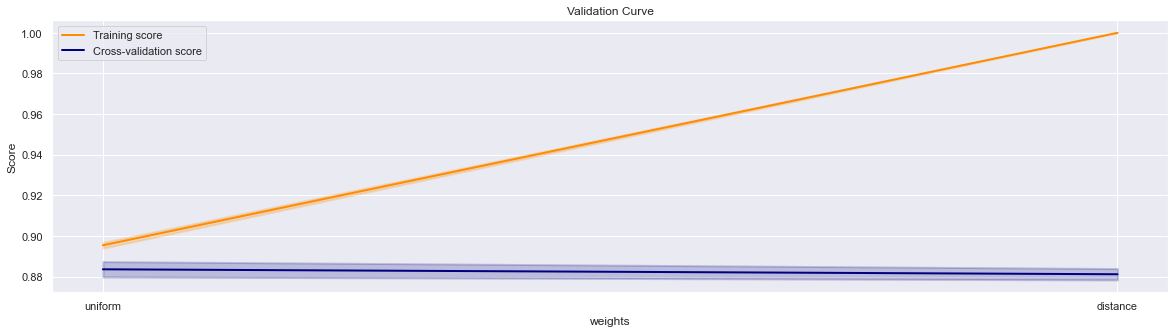

In [54]:
knn.n_neighbors=50
param_test={"param_range":["uniform", "distance"],
            "param_name":"weights"}

plot_validation_curve(knn,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


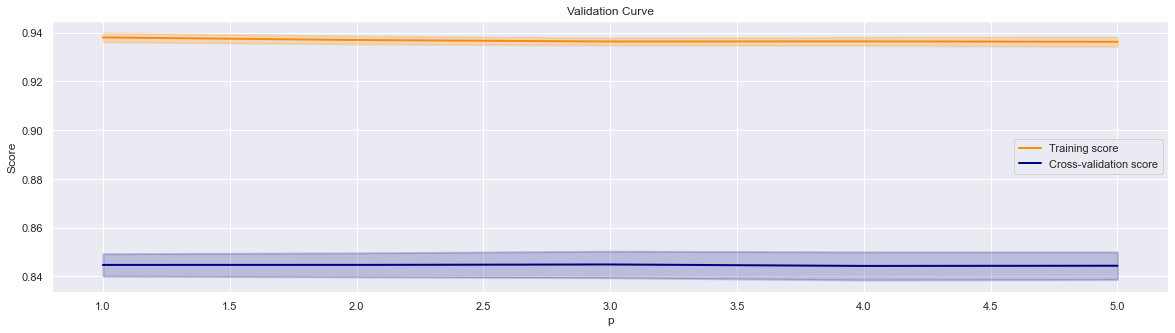

In [27]:
param_test={"param_range":[1,2,3,4,5],
            "param_name":"p"}

plot_validation_curve(knn,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

In [32]:
knn.p=1

In [33]:
knn,encoding,scaler,rslt=fit_cv(Knn,train,target,encoding,cat_feat,scaler,numeric_feat,cv,metrics_)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(32561, 108)
Metrica = ROC_AUC
run = 0 | metrica treino = 0.809893077554889 | metrica val = 0.7386435345305646
Metrica = Accuracy
run = 0 | metrica treino = 0.8767659705159705 | metrica val = 0.822815906648242
Metrica = Precision
run = 0 | metrica treino = 0.7772096420745069 | metrica val = 0.6587473002159827
Metrica = Recall
run = 0 | metrica treino = 0.6813960934998399 | metrica val = 0.5736677115987461
Metrica = ROC_AUC
run = 1 | metrica treino = 0.8092943011318704 | metrica val = 0.7496365167042885
Metrica = Accuracy
run = 1 | metrica treino = 0.8758877500095973 | metrica val = 0.8341523341523341
Metrica = Precision
run = 1 | metrica treino = 0.7772124295838634 | metrica val = 0.6762749445676275
Metrica = Recall
run = 1 | metrica treino = 0.6806174411203055 | metrica val = 0.5876685934489403
Metrica = ROC_AUC
run = 2 | metrica treino = 0.8072046873735901 | metrica val = 0.7484737506460374
Metrica = Accuracy
run = 2 | metrica treino = 0.8758109716303889 | metrica val = 0.83138820638

In [55]:
knn

KNeighborsClassifier(n_neighbors=50, p=1)

In [35]:
rslt.mean()

ROC_AUC_train     0.81
ROC_AUC_val       0.74
Accuracy_train    0.88
Accuracy_val      0.83
Precision_train   0.78
Precision_val     0.66
Recall_train      0.68
Recall_val        0.58
dtype: float64

In [36]:
X_train=encoding.fit_transform(train[cat_feat])
X_train[numeric_feat]=scaler.fit_transform(train[numeric_feat])

X_test=encoding.fit_transform(test[cat_feat])
X_test[numeric_feat]=scaler.fit_transform(test[numeric_feat])

missing_cols=list(set(X_train.columns)-set(X_test.columns))
X_test[missing_cols]=0

y_hat_test=knn.predict(X_test)
for name,metric in metrics_.items():
  metric_test=metric(test[target],y_hat_test)
  print("================== Test Performance =================")
  print("metric {} = {}".format(name,metric_test))

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


================== Test Performance =================
metric ROC_AUC = 0.5399946178788044
================== Test Performance =================
metric Accuracy = 0.7362569866715803
================== Test Performance =================
metric Precision = 0.37126436781609196
================== Test Performance =================
metric Recall = 0.16796671866874674


## Random Forest


In [37]:
rndmf,encoding,scaler,rslt=fit_cv(rndmForest,train,target,encoding,cat_feat,scaler,numeric_feat,cv,metrics_)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(32561, 108)
Metrica = ROC_AUC
run = 0 | metrica treino = 1.0 | metrica val = 0.7700506488225073
Metrica = Accuracy
run = 0 | metrica treino = 1.0 | metrica val = 0.8475356978350991
Metrica = Precision
run = 0 | metrica treino = 1.0 | metrica val = 0.7197080291970803
Metrica = Recall
run = 0 | metrica treino = 1.0 | metrica val = 0.6181818181818182
Metrica = ROC_AUC
run = 1 | metrica treino = 0.9999747027573995 | metrica val = 0.7842798416318477
Metrica = Accuracy
run = 1 | metrica treino = 0.9999616108103958 | metrica val = 0.8624078624078624
Metrica = Precision
run = 1 | metrica treino = 0.9998408910103421 | metrica val = 0.7513307984790875
Metrica = Recall
run = 1 | metrica treino = 1.0 | metrica val = 0.6345536287732819
Metrica = ROC_AUC
run = 2 | metrica treino = 0.999759538313562 | metrica val = 0.7702063392800751
Metrica = Accuracy
run = 2 | metrica treino = 0.9998848324311874 | metrica val = 0.8521191646191646
Metrica = Precision
run = 2 | metrica treino = 1.0 | metrica val = 0

In [38]:
rslt.mean()

ROC_AUC_train     1.00
ROC_AUC_val       0.78
Accuracy_train    1.00
Accuracy_val      0.85
Precision_train   1.00
Precision_val     0.73
Recall_train      1.00
Recall_val        0.62
dtype: float64

In [39]:
X_train=encoding.fit_transform(train[cat_feat])
X_train[numeric_feat]=scaler.fit_transform(train[numeric_feat])

X_test=encoding.fit_transform(test[cat_feat])
X_test[numeric_feat]=scaler.fit_transform(test[numeric_feat])

missing_cols=list(set(X_train.columns)-set(X_test.columns))
X_test[missing_cols]=0

y_hat_test=rndmf.predict(X_test)
for name,metric in metrics_.items():
  metric_test=metric(test[target],y_hat_test)
  print("================== Test Performance =================")
  print("metric {} = {}".format(name,metric_test))

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


================== Test Performance =================
metric ROC_AUC = 0.5489820388955485
================== Test Performance =================
metric Accuracy = 0.7726183895338125
================== Test Performance =================
metric Precision = 0.5880195599022005
================== Test Performance =================
metric Recall = 0.125065002600104


C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


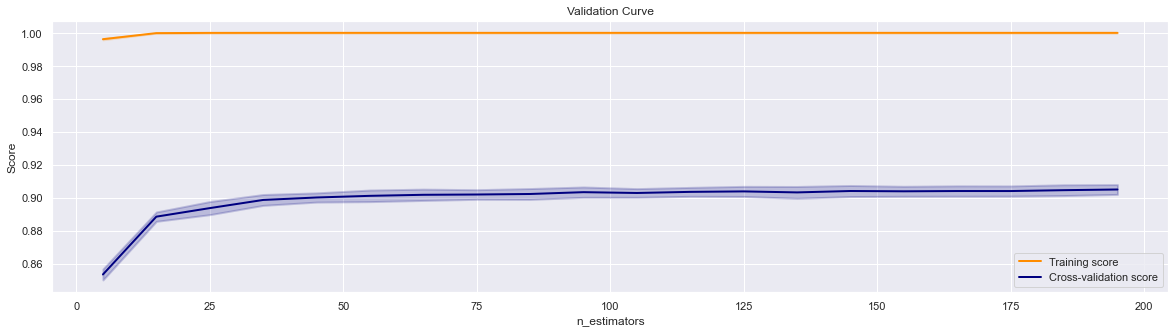

In [40]:
param_test={"param_range":list(range(5,200,10)),
            "param_name":"n_estimators"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


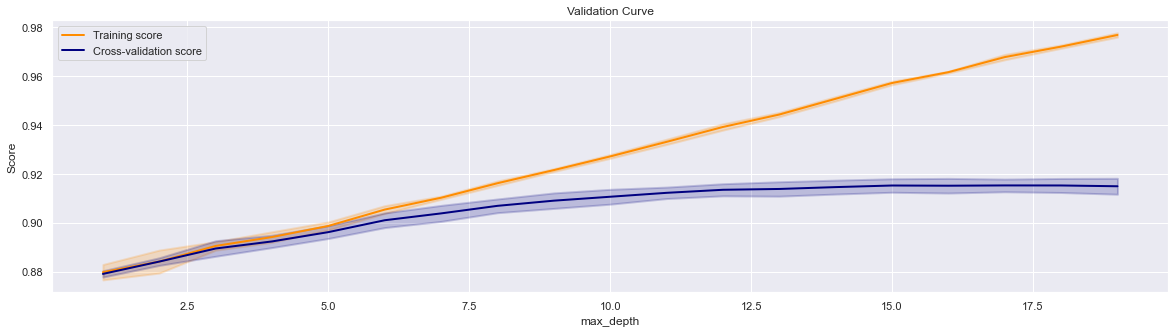

In [41]:
rndmf.n_estimators=50
param_test={"param_range":list(range(1,20,1)),
            "param_name":"max_depth"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


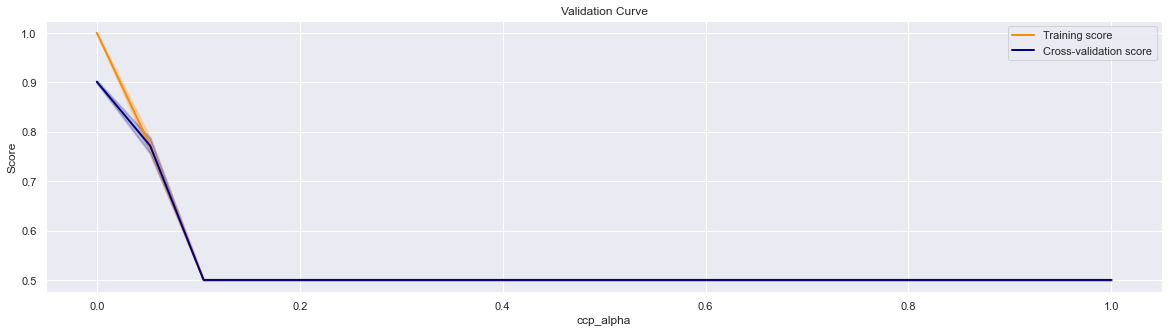

In [42]:
rndmf.max_depth=None #8
param_test={"param_range":np.linspace(0,1,20),
            "param_name":"ccp_alpha"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


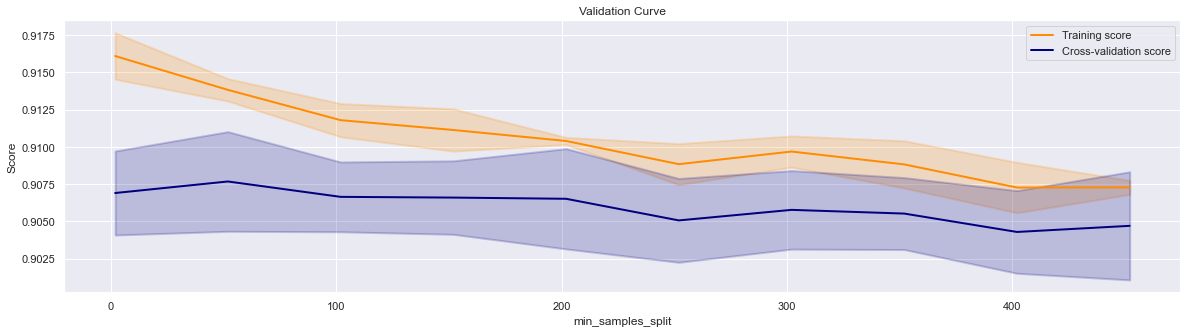

In [43]:
rndmf.max_depth=8
param_test={"param_range":list(range(2,500,50)),
            "param_name":"min_samples_split"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


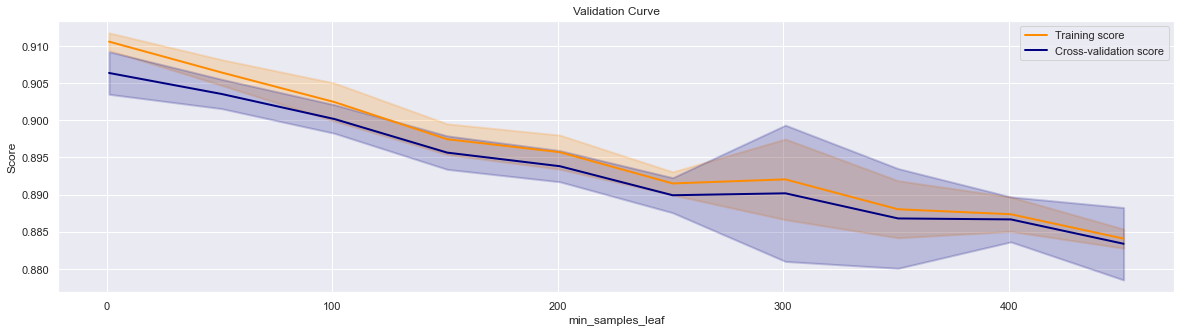

In [44]:
rndmf.min_samples_split=50
param_test={"param_range":list(range(1,500,50)),
            "param_name":"min_samples_leaf"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


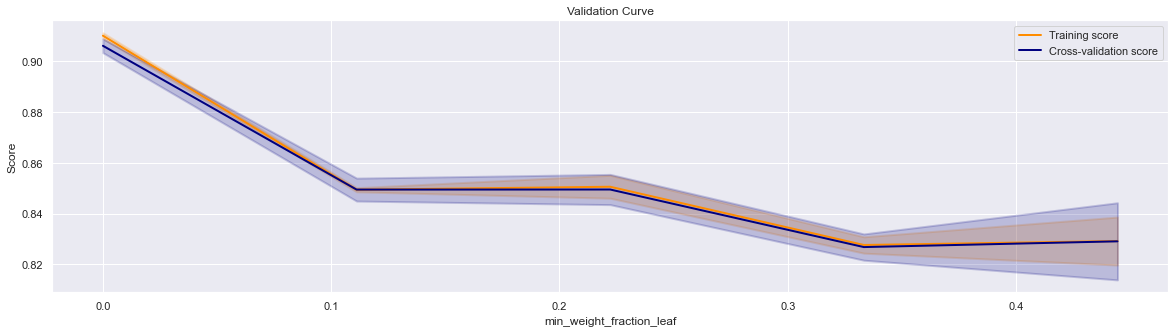

In [45]:
param_test={"param_range":np.linspace(0,1,10),
            "param_name":"min_weight_fraction_leaf"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


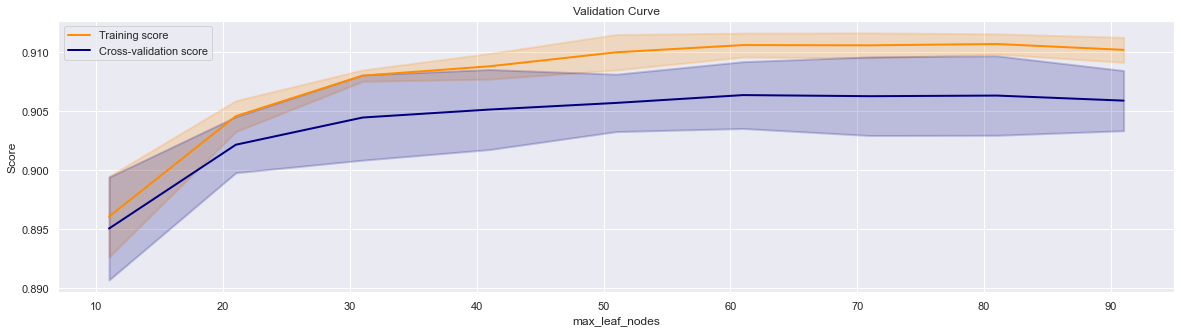

In [46]:
param_test={"param_range":list(range(1,100,10)),
            "param_name":"max_leaf_nodes"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


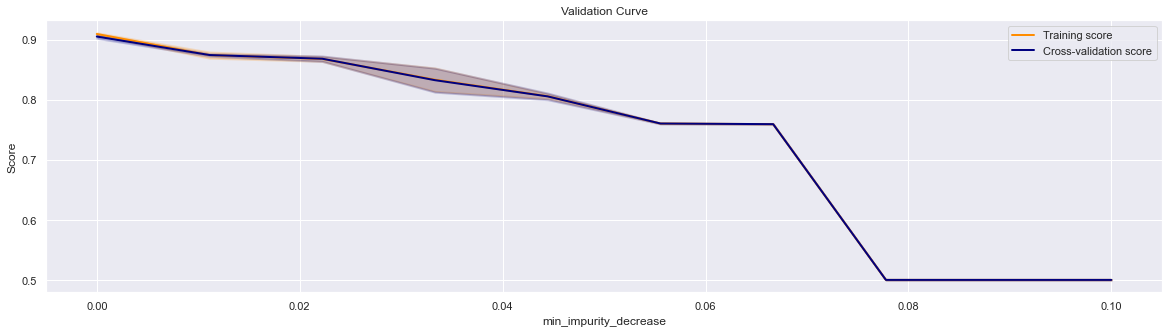

In [47]:
rndmf.max_leaf_nodes=72
param_test={"param_range":np.linspace(0,0.1,10),
            "param_name":"min_impurity_decrease"}

plot_validation_curve(rndmf,
                      X_train,
                      train[[target]].fillna(0),
                      scoring="roc_auc",
                      **param_test)

In [48]:
rndmf

RandomForestClassifier(max_depth=8, max_leaf_nodes=72, min_samples_split=200,
                       n_estimators=50)

In [49]:
rndmf,encoding,scaler,rslt=fit_cv(rndmForest,train,target,encoding,cat_feat,scaler,numeric_feat,cv,metrics_)

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(32561, 108)
Metrica = ROC_AUC
run = 0 | metrica treino = 0.7351123949708582 | metrica val = 0.7270443422600874
Metrica = Accuracy
run = 0 | metrica treino = 0.8523878992628993 | metrica val = 0.8440042990941194
Metrica = Precision
run = 0 | metrica treino = 0.8026216284345853 | metrica val = 0.7869177403369673
Metrica = Recall
run = 0 | metrica treino = 0.5097662504002561 | metrica val = 0.49780564263322885
Metrica = ROC_AUC
run = 1 | metrica treino = 0.7359403328060793 | metrica val = 0.7435120969910959
Metrica = Accuracy
run = 1 | metrica treino = 0.8505508848708204 | metrica val = 0.8573402948402948
Metrica = Precision
run = 1 | metrica treino = 0.7933742331288344 | metrica val = 0.8115079365079365
Metrica = Recall
run = 1 | metrica treino = 0.5144812221514958 | metrica val = 0.525369299935774
Metrica = ROC_AUC
run = 2 | metrica treino = 0.7358995011677278 | metrica val = 0.7273536187686385
Metrica = Accuracy
run = 2 | metrica treino = 0.8529694038158855 | metrica val = 0.847051597

In [50]:
rslt.mean()

ROC_AUC_train     0.74
ROC_AUC_val       0.73
Accuracy_train    0.85
Accuracy_val      0.85
Precision_train   0.80
Precision_val     0.79
Recall_train      0.51
Recall_val        0.51
dtype: float64

In [51]:
X_train=encoding.fit_transform(train[cat_feat])
X_train[numeric_feat]=scaler.fit_transform(train[numeric_feat])

X_test=encoding.fit_transform(test[cat_feat])
X_test[numeric_feat]=scaler.fit_transform(test[numeric_feat])

missing_cols=list(set(X_train.columns)-set(X_test.columns))
X_test[missing_cols]=0

y_hat_test=rndmf.predict(X_test)
for name,metric in metrics_.items():
  metric_test=metric(test[target],y_hat_test)
  print("================== Test Performance =================")
  print("metric {} = {}".format(name,metric_test))

C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\99823827\Anaconda3\envs\GFAF_model\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


================== Test Performance =================
metric ROC_AUC = 0.5154584180954693
================== Test Performance =================
metric Accuracy = 0.7665376819605675
================== Test Performance =================
metric Precision = 0.5868725868725869
================== Test Performance =================
metric Recall = 0.039521580863234526


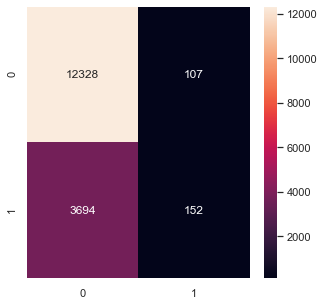

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(5,5))
sns.heatmap(metrics.confusion_matrix(test[target], y_hat_test),annot=True,fmt="")
plt.show()

## Neural Networks

In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers.convolutional import Conv2D
from tensorflow.keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers.core import Activation
from tensorflow.keras.layers.core import Dropout
from tensorflow.keras.layers.core import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
 
def create_mlp(dim, regress=True):
    # define our MLP (Multilayer Perceptron) network
    model = Sequential()
    # hidden layer 1
    model.add(Dense(40, input_dim=dim, activation="relu"))
    # hidden layer 2
    model.add(Dense(20, activation="relu"))
    
    # check to see if the regression node should be added
    if regress:
        # output layer
        model.add(Dense(1, activation="linear"))
    
    # return our model
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam

model = create_mlp(trainX.shape[1], regress=True)
opt = Adam(lr=0.001)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mae', 'mse'])
 
# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=64)

In [ ]:
# evaluate the model
train_mse = model.evaluate(trainX, trainY, verbose=0)
test_mse = model.evaluate(testX, testY, verbose=0)
print('Train: {}, Test: {}'.format(train_mse, test_mse))

In [ ]:
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize': (15, 8), 'figure.dpi': 190})

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()


# plot loss while training the data
plot_history(history)
